In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install ultralytics torch

In [ ]:
# To display the image
from PIL import Image

friends_img = Image.open("friends.webp")

In [92]:
friends_img.size #(w,h)

(1200, 1200)

In [93]:
# Width transformation
mywidth = 600
wpercent = mywidth / float(friends_img.size[0])
wpercent

0.5

In [94]:
# Height transformation
hsize = int( float(friends_img.size[1]) * wpercent )
hsize

600

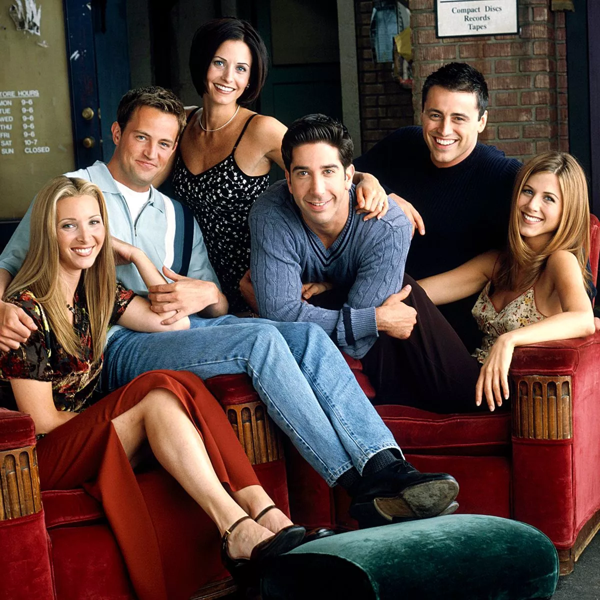

In [95]:
# Resize
friends_img = friends_img.resize([mywidth, hsize])
friends_img

In [ ]:
# Save the resized image
image_path_resized = "friends_resized.jpg"
friends_img.save(image_path_resized)

### Detecting Faces

Info about ['google/owlvit-base-patch32'](https://huggingface.co/google/owlvit-base-patch32)

In [ ]:
# Load the model
detector = pipeline(
    model= "google/owlvit-base-patch32",
    task="zero-shot-object-detection"
)

In [97]:
# Apply detector model to detect female face
output = detector(
    friends_img,
    candidate_labels=["human face"]
)

In [98]:
output

[{'score': 0.5993408560752869,
  'label': 'human face',
  'box': {'xmin': 289, 'ymin': 141, 'xmax': 347, 'ymax': 222}},
 {'score': 0.598851203918457,
  'label': 'human face',
  'box': {'xmin': 422, 'ymin': 87, 'xmax': 478, 'ymax': 163}},
 {'score': 0.5954024791717529,
  'label': 'human face',
  'box': {'xmin': 119, 'ymin': 108, 'xmax': 179, 'ymax': 183}},
 {'score': 0.5869125723838806,
  'label': 'human face',
  'box': {'xmin': 204, 'ymin': 40, 'xmax': 251, 'ymax': 105}},
 {'score': 0.5731284618377686,
  'label': 'human face',
  'box': {'xmin': 55, 'ymin': 191, 'xmax': 106, 'ymax': 268}},
 {'score': 0.5425328016281128,
  'label': 'human face',
  'box': {'xmin': 515, 'ymin': 170, 'xmax': 561, 'ymax': 235}}]

In [99]:
from utils import preprocess_outputs

input_scores, input_labels, input_boxes = preprocess_outputs(output)
input_boxes

[[[289, 141, 347, 222],
  [422, 87, 478, 163],
  [119, 108, 179, 183],
  [204, 40, 251, 105],
  [55, 191, 106, 268],
  [515, 170, 561, 235]]]

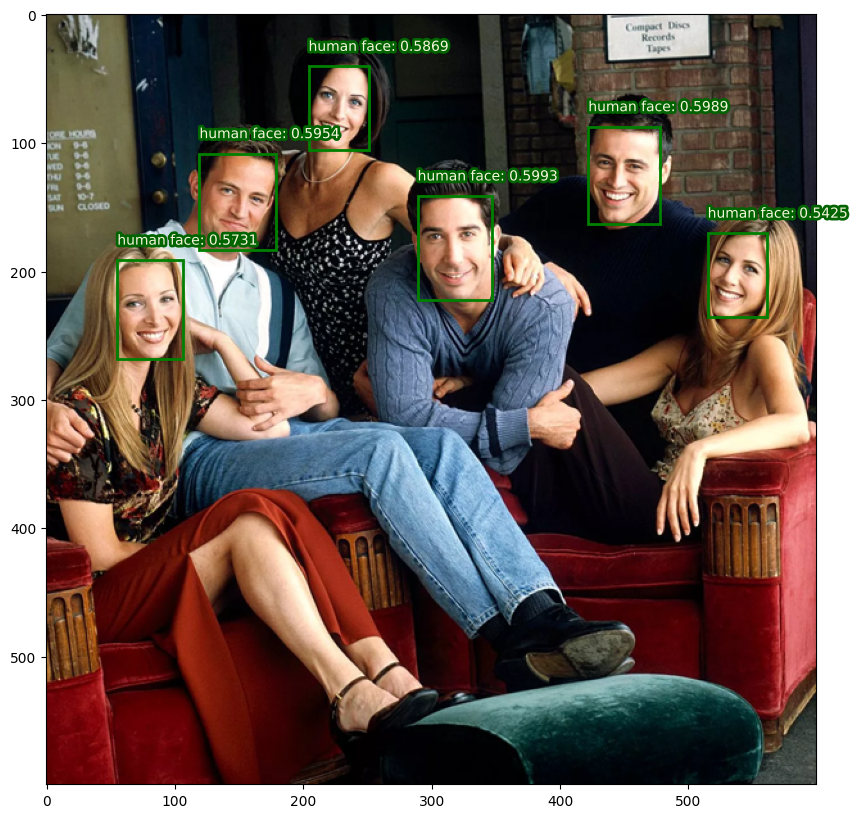

In [100]:
from utils import show_boxes_and_labels_on_image

# Show the image with the bounding boxes
show_boxes_and_labels_on_image(
    friends_img,
    input_boxes[0],
    input_labels,
    input_scores
)

### Get segmentation masks using Mobile SAM

Info about [mobile_sam.pt](https://docs.ultralytics.com/models/mobile-sam/)

In [101]:
# Load the SAM model from the imported ultralytics library
from ultralytics import SAM

SAM_version = "/content/drive/MyDrive/mobile_sam.pt"

model = SAM(SAM_version) #mobileSAM to create mask from bounding box

In [103]:
import numpy as np

result = model.predict(
    image_path_resized, #path
    bboxes=input_boxes[0],
    labels=np.repeat(1, len(input_boxes[0])) # [1,1,1] for class labels
)


image 1/1 /content/friends_resized.jpg: 1024x1024 108.6ms
Speed: 9.6ms preprocess, 108.6ms inference, 0.3ms postprocess per image at shape (1, 3, 1024, 1024)


In [104]:
masks = result[0].masks.data

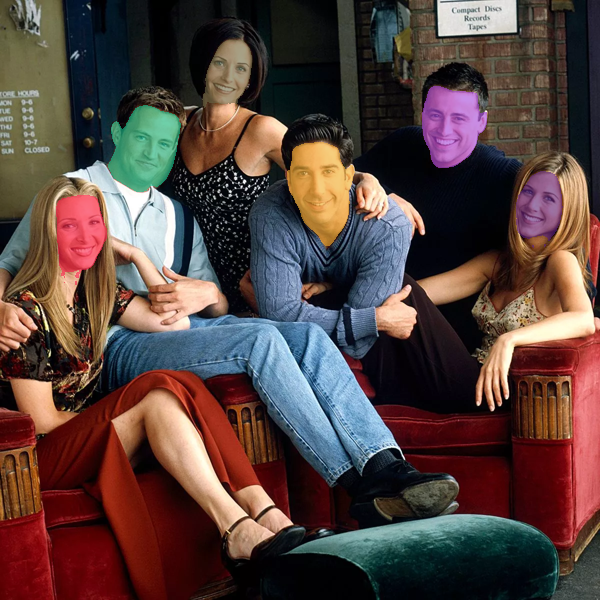

In [105]:
from utils import show_masks_on_image

show_masks_on_image(
    friends_img,
    masks
)

I need to blurr the portion of segmented mask. So I have to replace the segemented object with blurred object. Hence, I am blurring the whole image first.

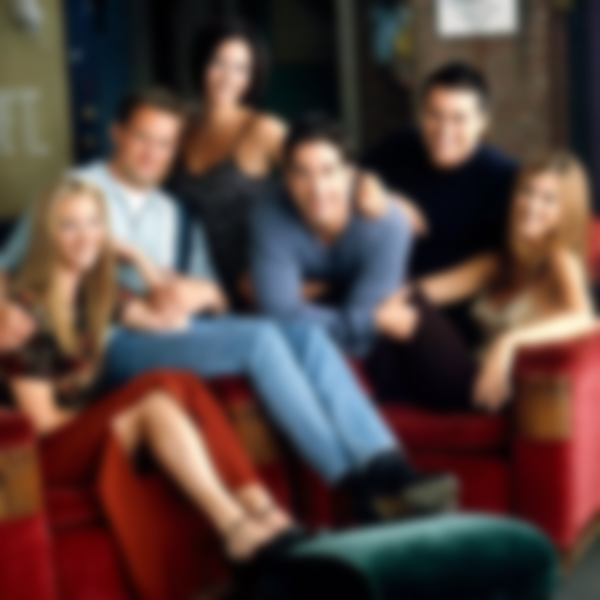

In [106]:
from PIL.ImageFilter import GaussianBlur

blurred_img = friends_img.filter(GaussianBlur(radius=5))
blurred_img

Now I will be using the single mask to replace parts of the image with the blurred out image.

In [107]:
result[0].masks.data

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [108]:
masks = result[0].masks.data.cpu().numpy()
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [109]:
masks[0].shape

(600, 600)

In [110]:
# Obtain only a single mask
total_mask = np.zeros(masks[0].shape)

for mask in masks:
    total_mask = np.add(total_mask,mask)

In [111]:
'''
np.where checks the condition np.expand_dims(total_mask != 0, axis=2).
Where the condition is True (indicating a face or another region to blur), it takes pixels from blurred_img.
Where the condition is False (indicating background or regions not to blur), it takes pixels from friends_img.
'''

output = np.where(
    np.expand_dims(total_mask != 0, axis=2),
    blurred_img,
    friends_img
)

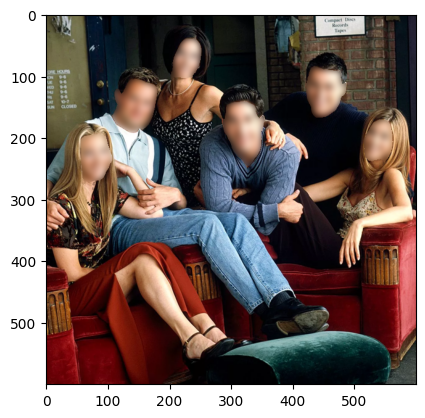

In [112]:
from matplotlib import pyplot as plt

# Print image with faces blured
plt.imshow(output)